# Feature Creation (Supplemental Material)

---

Feature creation is carried out in [reviewed_grapes.feature_eng.pyspark.v1.ipynb](reviewed_grapes.feature_eng.pyspark.v1.ipynb) and the ML models created in this project are independent on the feature engineering steps carried out here.

In this notebook we simply do some further exploration and alternative implementations based on other libraries.

In particular we implement an auto-encoder structure and perform a word-2-vector embedding in [keras](https://keras.io/).

We then deploy this model on apache spark worker nodes using [elephas](https://github.com/maxpumperla/elephas).

---

In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from functools import partial
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from pyspark import keyword_only
from pyspark.ml import Pipeline, Transformer, Estimator, Model
from pyspark.ml.feature import (VectorAssembler, StringIndexer,
                                StringIndexerModel, OneHotEncoder,
                                OneHotEncoderModel, Bucketizer)
from pyspark.ml.base import _FitMultipleIterator
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.param.shared import HasInputCol, HasInputCols, HasOutputCol, HasOutputCols, Param, Params
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.functions import lit, udf, explode, col
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType, FloatType

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/jonas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
%matplotlib inline
def warn(string):
    display(Markdown('<span style="color:red">'+string+'</span>'))
def info(string):
    display(Markdown('<span style="color:blue">'+string+'</span>'))

To process the text in the `description` column for a dataset with over 100k rows, we need to switch gears and start to parallelize.
So we move from a pandas dataframe to a resilient distributed dataset (rdd) using pyspark:

In [4]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.driver.memory", "20g") \
    .appName("jojoSparkSession") \
    .getOrCreate()
    # .config("spark.driver.memory", "20g") \
    # .config("spark.default.parallelism", "16") \
    # .config("spark.executor.cores", "16") \
sc = spark.sparkContext
sqlContext = SQLContext(sc) 

Start with some import and loading the dataset:

_If the parquet file is not defined make sure to run all cells in [Baseline_Model_0.ipynb](./Baseline_Model_0.ipynb) up to (including) [Feature Enigneering](./Baseline_Model_0.ipynb#Feature_Enineering)._

In [5]:
# load the dataset
reviews_sdf = spark.read.parquet('data/reviews_cleaned')
reviews_sdf.show()

+-----+--------------------+------------------+
|index|         description|           variety|
+-----+--------------------+------------------+
|    0|aromas include tr...|       white blend|
|    1|this is ripe and ...|    portuguese red|
|    2|tart and snappy, ...|        pinot gris|
|    3|pineapple rind, l...|          riesling|
|    4|much like the reg...|        pinot noir|
|    7|this dry and rest...|    gewürztraminer|
|    8|savory dried thym...|    gewürztraminer|
|    9|this has great de...|        pinot gris|
|   10|soft, supple plum...|cabernet sauvignon|
|   11|this is a dry win...|    gewürztraminer|
|   12|slightly reduced,...|cabernet sauvignon|
|   14|building on 150 y...|        chardonnay|
|   15|zesty orange peel...|          riesling|
|   16|baked plum, molas...|            malbec|
|   17|raw black-cherry ...|            malbec|
|   18|desiccated blackb...| tempranillo blend|
|   19|red fruit aromas ...|          meritage|
|   20|ripe aromas of da...|         red

In [32]:
from reviewed_grapes.transformers import NLTKLemmatizer
from utils.Estimators import WordSetTracker

[nltk_data] Downloading package punkt to /home/jonas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Index the labels:
si = StringIndexer(inputCol='variety', outputCol='label', handleInvalid='keep')
# Create canonical word list
from nltk.corpus import stopwords
# get common english stopwords:
en_stopwords = set(stopwords.words('english'))
blacklist = set(['wine', 'drink', 'variety', 'show', 'offer', 'make', 'give', 'well',
                 'open', 'come', 'years', 'bottle', 'mouth', 'like', 'also', 'along',
                 'alongside', 'vineyard', 'ready', 'great', 'one', 'slightly', 'deliver',
                 'yet', 'add', 'need', 'big', 'bring', 'easy', 'oral', 'best', 'end', 'alcohol'])
stop_words = list(en_stopwords.union(blacklist))
nltkl = NLTKLemmatizer(inputCol='description', outputCol='words', stopWords=stop_words)
# Compute list of most common words
# (we use indexWords=False to create a list of words instead of features)
nbrWords = 500
# TODO: move wst after upscaling
wst = WordSetTracker(inputCol='words', outputCol='word_list',
                     limitTo=nbrWords, indexWords=False)
# Set up a pipeline
prep_ppl = Pipeline(stages=[si, nltkl, wst])

In [8]:
%%time
listing_ppl = prep_ppl.fit(reviews_sdf)
ndf = listing_ppl.transform(reviews_sdf)
wst_model = listing_ppl.stages[-1]

CPU times: user 75.1 ms, sys: 9.61 ms, total: 84.7 ms
Wall time: 1min 13s


In [9]:
ndf.show()

+-----+--------------------+------------------+-----+--------------------+--------------------+
|index|         description|           variety|label|               words|           word_list|
+-----+--------------------+------------------+-----+--------------------+--------------------+
|    0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|[fruit, aromas, p...|
|    1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|[fruit, acidity, ...|
|    2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|[flavor, acidity,...|
|    3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|[finish, aromas, ...|
|    4|much like the reg...|        pinot noir|  0.0|[bottle, winter, ...|[good, tannic, he...|
|    7|this dry and rest...|    gewürztraminer| 26.0|[firm, much, offe...|[acidity, dry, sp...|
|    8|savory dried thym...|    gewürztraminer| 26.0|[accent, elegant,...|[flavor, dry, not...|
|    9|this has great de...|        pino

In [10]:
# StringIndexer is rather helpful as it associates the index 0.0 to the most common lable.
# We can thus easily get to count of the most common label with: 
target_count = ndf.filter(ndf.label==0.0).count()
print(f'{target_count=}')

target_count=12277


Now we 'upscale' the number of samples for any other label, in order to get the same count for each label.
We do this by sampling with replacement:

In [11]:
# get all different labels present (i.e. all wine varieties)
all_labels = sorted(np.array(ndf.select('label').distinct().collect()).reshape(-1))
# number of different labels (i.e. varieties)
nbr_labels = len(all_labels)
total_count = ndf.count()
print(f'{total_count=}')
# we construct a new dataset that will hold the balanced review data
new_ndf = ndf.alias('new_ndf')
# now we process each label
# (with the exception of the first as there is nothing to do)
for label in all_labels[1:]:
    label_entries = ndf.filter(ndf.label==label)
    nbr_entries = label_entries.count()
    needed = target_count - nbr_entries
    upscale_factor = needed / nbr_entries
    # now we sample
    new_entries = ndf.sample(True, upscale_factor).take(needed)
    new_ndf = new_ndf.union(sc.parallelize(new_entries).toDF())
    added = len(new_entries)
    print(f'processing {label=}\n\tgot a count of {nbr_entries}\n\t{added=}')

total_count=108234
processing label=1.0
	got a count of 10867
	added=1410
processing label=2.0
	got a count of 8838
	added=3439
processing label=3.0
	got a count of 8241
	added=4036
processing label=4.0
	got a count of 6469
	added=5808
processing label=5.0
	got a count of 4773
	added=7504
processing label=6.0
	got a count of 4575
	added=7702
processing label=7.0
	got a count of 3826
	added=8451
processing label=8.0
	got a count of 3220
	added=9057
processing label=9.0
	got a count of 2896
	added=9381
processing label=10.0
	got a count of 2602
	added=9675
processing label=11.0
	got a count of 2530
	added=9747
processing label=12.0
	got a count of 2460
	added=9817
processing label=13.0
	got a count of 2446
	added=9831
processing label=14.0
	got a count of 2282
	added=9995
processing label=15.0
	got a count of 2179
	added=10098
processing label=16.0
	got a count of 1971
	added=10306
processing label=17.0
	got a count of 1671
	added=10606
processing label=18.0
	got a count of 1343
	added=1

In [12]:
print(new_ndf.count())
print(ndf.count())

699789
108234


In [13]:
@udf(returnType=ArrayType(StringType()))
def w2v_sentence(words_list, variety):
    _sep = '  '
    return f'{_sep}{variety}{_sep}'.join(words_list).split(_sep)
new_ndf = new_ndf.withColumn('ww', w2v_sentence(new_ndf['word_list'], new_ndf['variety']))
# now we can do word2vec on column 'ww' with vectorSize=1

In [14]:
new_ndf.show()

+-----+--------------------+------------------+-----+--------------------+--------------------+--------------------+
|index|         description|           variety|label|               words|           word_list|                  ww|
+-----+--------------------+------------------+-----+--------------------+--------------------+--------------------+
|    0|aromas include tr...|       white blend| 15.0|[herb, overly, of...|[fruit, aromas, p...|[fruit, white ble...|
|    1|this is ripe and ...|    portuguese red| 14.0|[still, better, c...|[fruit, acidity, ...|[fruit, portugues...|
|    2|tart and snappy, ...|        pinot gris| 19.0|[poke, flavor, fe...|[flavor, acidity,...|[flavor, pinot gr...|
|    3|pineapple rind, l...|          riesling|  5.0|[opulent, aromas,...|[finish, aromas, ...|[finish, riesling...|
|    4|much like the reg...|        pinot noir|  0.0|[bottle, winter, ...|[good, tannic, he...|[good, pinot noir...|
|    7|this dry and rest...|    gewürztraminer| 26.0|[firm, much

In [15]:
%%time
words = new_ndf.select('index', 'variety', explode('word_list').alias('word'))
words.show(5)

+-----+-----------+-------+
|index|    variety|   word|
+-----+-----------+-------+
|    0|white blend|  fruit|
|    0|white blend| aromas|
|    0|white blend| palate|
|    0|white blend|acidity|
|    0|white blend|    dry|
+-----+-----------+-------+
only showing top 5 rows

CPU times: user 7.25 ms, sys: 1.5 ms, total: 8.75 ms
Wall time: 13.3 s


In [16]:
import utils.Estimators as Estimators

In [17]:
# from imp import reload
# reload(utils.Estimators)

In [18]:
csi = Estimators.CompositeStringIndexer(inputCols=['variety', 'word'], outputCols=['label', 'word_indices'])
# bzier = Bucketizer(inputCol='id', outputCol='id_bucket')
cohenc = Estimators.CompositeOneHotEncoder(inputCols=['label', 'word_indices'], outputCols=['label_enc', 'wi_enc'])

In [19]:
%%time
words_model = Pipeline(stages=[csi, cohenc]).fit(words)
words_enc = words_model.transform(words)
words_enc.show()

+-----+--------------+---------+-----+------------+----------------+-----------------+
|index|       variety|     word|label|word_indices|       label_enc|           wi_enc|
+-----+--------------+---------+-----+------------+----------------+-----------------+
|    0|   white blend|    fruit|  7.0|        13.0| (548,[7],[1.0])| (548,[13],[1.0])|
|    0|   white blend|   aromas|  7.0|        16.0| (548,[7],[1.0])| (548,[16],[1.0])|
|    0|   white blend|   palate|  7.0|        18.0| (548,[7],[1.0])| (548,[18],[1.0])|
|    0|   white blend|  acidity|  7.0|        22.0| (548,[7],[1.0])| (548,[22],[1.0])|
|    0|   white blend|      dry|  7.0|        34.0| (548,[7],[1.0])| (548,[34],[1.0])|
|    0|   white blend|    offer|  7.0|        44.0| (548,[7],[1.0])| (548,[44],[1.0])|
|    0|   white blend|    apple|  7.0|        64.0| (548,[7],[1.0])| (548,[64],[1.0])|
|    0|   white blend|   citrus|  7.0|        71.0| (548,[7],[1.0])| (548,[71],[1.0])|
|    0|   white blend|     herb|  7.0|     

In [20]:
cismodel = words_model.stages[0]
# how many words to we have?
nbr_words = len(cismodel.labelsArray[0])
print(nbr_words)

548


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import serialize, Adam
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
autoenc = Sequential()

input = Dense(nbr_words, input_shape=(nbr_words,), activation='relu')
autoenc.add(input)
bottleneck = Dense(50, activation='relu')
autoenc.add(bottleneck)
autoenc.add(Dense(nbr_words, activation='softmax'))

# needs to be configured
adam_conf = serialize(Adam())

autoenc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
autoenc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 548)               300852    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                27450     
_________________________________________________________________
dense_2 (Dense)              (None, 548)               27948     
Total params: 356,250
Trainable params: 356,250
Non-trainable params: 0
_________________________________________________________________


And we prepare some function to plot the history:

In [23]:
import matplotlib.pyplot as plt

def plot_history(history, axs=None):
    acc = history['acc']
    #val_acc = history.history['val_acc']
    loss = history['loss']
    #val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    if axs is None:
        fig = plt.figure(figsize=(12, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_title('Training accuracy')
        ax1.set_xlabel('epochs')
        ax2.set_title('Training loss')
        ax2.set_xlabel('epochs')
    else:
        ax1, ax2 = axs
    ax1.plot(x, acc, 'b', label='Training acc')
    # ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax2.plot(x, loss, 'b', label='Training loss')
    # ax2.plot(x, val_loss, 'r', label='Validation loss')
    if axs is None:
        ax1.legend()
        ax2.legend()

---
**Now we transition out of spark...**

In [38]:
words_enc_sample = words_enc.sample(0.01)
x_sdf = words_enc_sample.select('wi_enc')
y_sdf = words_enc_sample.select('label_enc')

In [39]:
%%time
x = np.array(x_sdf.cache().collect())

CPU times: user 6min 11s, sys: 2.61 s, total: 6min 13s
Wall time: 8min 26s


In [40]:
%%time
y = np.array(y_sdf.cache().collect())

CPU times: user 2min 11s, sys: 1.72 s, total: 2min 13s
Wall time: 4min 16s


In [41]:
x = x.reshape(x.shape[0], x.shape[-1])
y = y.reshape(y.shape[0], y.shape[-1])

In [6]:
import pickle

In [43]:
with open('data/interim/enc_samples.p', 'wb') as fobj:
    pickle.dump((x, y), fobj)

In [7]:
with open('data/interim/enc_samples.p', 'rb') as fobj:
    x, y = pickle.load(fobj)

In [8]:
callback = EarlyStopping(monitor='acc', patience=3)

In [9]:
%%time
history = autoenc.fit(x, y, batch_size=256, epochs=50, verbose=1, callbacks=[callback])

Epoch 1/50
429/429 [==============================] - 6s 12ms/step - loss: 0.0558 - acc: 0.0869
Epoch 2/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0080 - acc: 0.1092
Epoch 3/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0079 - acc: 0.1329
Epoch 4/50
429/429 [==============================] - 5s 11ms/step - loss: 0.0077 - acc: 0.1589
Epoch 5/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0076 - acc: 0.1736
Epoch 6/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0075 - acc: 0.1812
Epoch 7/50
429/429 [==============================] - 6s 13ms/step - loss: 0.0074 - acc: 0.1868
Epoch 8/50
429/429 [==============================] - 5s 12ms/step - loss: 0.0073 - acc: 0.1890
Epoch 9/50
429/429 [==============================] - 6s 14ms/step - loss: 0.0072 - acc: 0.1897
Epoch 10/50
429/429 [==============================] - 5s 13ms/step - loss: 0.0071 - acc: 0.1907
Epoch 11/50
429/429 [==================

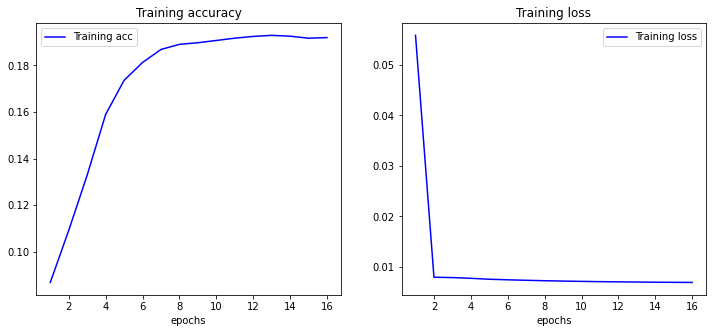

In [22]:
plot_history(history.history)

---
**Using elephas we can remain in spark...**

In [24]:
words_enc_sample = words_enc.sample(0.01)
rdd = words_enc_sample.select(words_enc_sample['wi_enc'].alias('features'), words_enc_sample['label_enc'].alias('labels')).rdd

In [25]:
rdd = rdd.repartition(8)

In [26]:
from elephas.spark_model import SparkModel

spark_model = SparkModel(autoenc, frequency='epoch', mode='synchronous')

In [27]:
epochs = 15
batch_size = 32

In [28]:
%%time
history1 = spark_model.fit(rdd, epochs=epochs, batch_size=batch_size, verbose=2)

>>> Fit model
>>> Synchronous training complete.
CPU times: user 176 ms, sys: 75.1 ms, total: 251 ms
Wall time: 10min 28s


Text(0.5, 0, 'epochs')

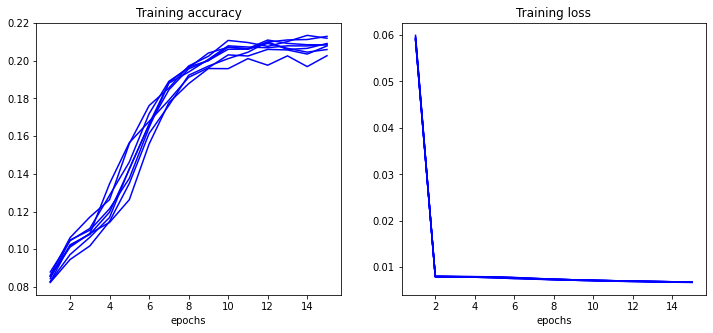

In [31]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for history in spark_model.training_histories:
    plot_history(history, (ax1, ax2))
ax1.set_title('Training accuracy')
ax1.set_xlabel('epochs')
ax2.set_title('Training loss')
ax2.set_xlabel('epochs')

In [53]:
spark_model.predict(rdd)

[array([[0.01388988, 0.0125505 , 0.01227295, 0.01294303, 0.01321519,
         0.01294885, 0.01307439, 0.01264841, 0.01333193, 0.01319459,
         0.01302043, 0.01236023, 0.01227725, 0.01248727, 0.01305287,
         0.01341909, 0.0135069 , 0.01338072, 0.01311118, 0.01317545,
         0.01272482, 0.01301851, 0.01272711, 0.01314294, 0.01217608,
         0.01378036, 0.01259174, 0.0127408 , 0.01255512, 0.01296988,
         0.01422813, 0.01404832, 0.01281425, 0.01222933, 0.01243177,
         0.01447191, 0.01305048, 0.01360749, 0.01242958, 0.01323222,
         0.01275034, 0.01285136, 0.01289788, 0.01342607, 0.01172645,
         0.01343505, 0.01362607, 0.01337893, 0.01304312, 0.01286519,
         0.0123709 , 0.01272061, 0.01294407, 0.0124382 , 0.01254708,
         0.01311313, 0.01270697, 0.01275152, 0.01288905, 0.01336171,
         0.01308525, 0.01202762, 0.01300148, 0.01347787, 0.0138164 ,
         0.01295142, 0.01206116, 0.01306635, 0.01314753, 0.01302619,
         0.01363804, 0.01230231, 0

---
---
---